In [4]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker
    

In [2]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

role_name = 'SageMakerAccessRole'
iam_client = boto3.client('iam', region_name='us-west-2')
role = iam_client.get_role(RoleName=role_name)['Role']['Arn']
sagemaker_role = role
boto3_session = boto3.Session(region_name='us-west-2')
sagemaker_session = sagemaker.Session(boto_session=boto3_session)


sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\renal\AppData\Local\sagemaker\sagemaker\config.yaml


In [6]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
import ipywidgets as widgets

filter_value = "task == txt2img"
txt2img_av_mod = list_jumpstart_models(filter=filter_value)
model_dropdown = widgets.Dropdown(
    options=txt2img_av_mod,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select the model to use:",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
model_id, model_version = model_dropdown.value, "*"


A Jupyter Widget

In [8]:

endpoint_name = name_from_base(f"jumpstart-model-{model_id}") #A

deployment_instance_type = "ml.p3.2xlarge"

deploy_image_uri = image_uris.retrieve(
    region='us-west-2',
    framework=None,
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=deployment_instance_type,
)#B

model_uri = model_uris.retrieve(
    region='us-west-2',
    model_id=model_id, model_version=model_version, model_scope="inference"
)


Using model 'model-txt2img-stabilityai-stable-diffusion-v2-1-base' with wildcard version identifier '1.*'. You can pin to version '1.1.3' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [10]:
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

sagemaker_model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=sagemaker_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
    sagemaker_session=sagemaker_session
)

model_endpoint = sagemaker_model.deploy(
    initial_instance_count=1,
    instance_type=deployment_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)


-----------!

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def send_query(predictor, text):
    encoded_text = text.encode("utf-8")
    response = predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return response

def interpret_response(response):
    result = json.loads(response)
    return result["generated_image"], result["prompt"] #B

def show_image_and_prompt(image_data, title):
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(image_data))
    plt.axis('off')
    plt.title(title)
    plt.show()


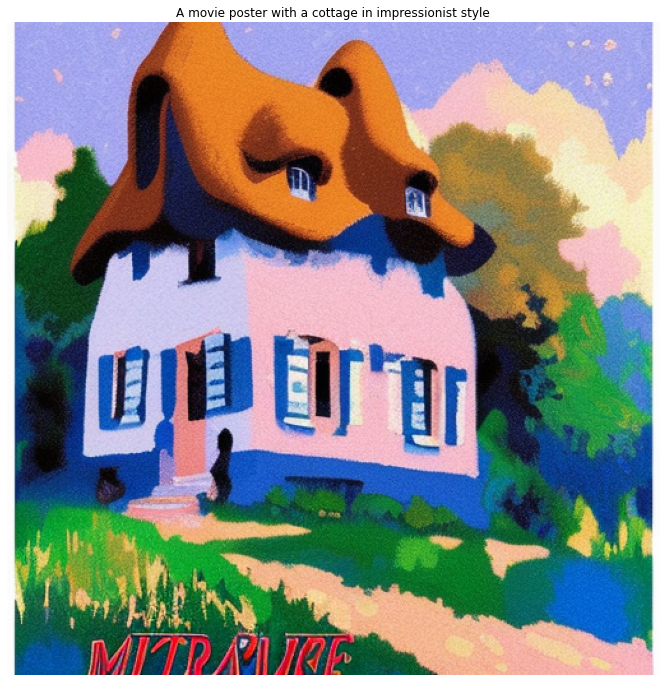

In [21]:
text = "A movie poster with a cottage in impressionist style"
query_response = send_query(model_endpoint, text)
img, prmpt = interpret_response(query_response)
show_image_and_prompt(img, prmpt)


In [ ]:
model_predictor.delete_model()
model_predictor.delete_endpoint()
